# Classification of Cardiopathies based on Electrocardiograms (ECGs)

This dataset consists of two collections of heartbeat signals derived from two famous datasets in heartbeat classification, the arrhythmia dataset [KAGGLE](https://www.kaggle.com/shayanfazeli/heartbeat). The number of samples in both collections is large enough to train a deep neural network.

This dataset has been used to explore heartbeat classification using deep neural network architectures and to observe some of the transfer learning capabilities in it.

The signals correspond to electrocardiogram (ECG) heartbeat patterns for both the normal case and cases affected by various arrhythmias and myocardial infarction. These signals are preprocessed and segmented, and each segment corresponds to a heartbeat.

In [53]:
import datetime
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# set cuda lib path
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/opt/cuda"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Training verbosity
VERBOSE = 1

# TB callbacks
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
TBLOGDIRS = {"mitbih": "logs/mitbih/tb_"}
TBLOGDIRS = {k: v + current_time for (k, v) in TBLOGDIRS.items()}
tensorboard = TensorBoard(TBLOGDIRS["mitbih"], histogram_freq=1)

# Data paths
TRAIN_PATH = "data/mitbih_train.csv"
TEST_PATH = "data/mitbih_test.csv"

# SEED
SEED = 42
# set seed for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Dataset

### Abstract
This dataset is composed of two collections of heartbeat signals derived from two famous datasets in heartbeat classification, the [MIT-BIH Arrhythmia Dataset](https://www.physionet.org/content/mitdb/1.0.0/) and [The PTB Diagnostic ECG Database](https://www.physionet.org/content/ptbdb/1.0.0/). The number of samples in both collections is large enough for training a deep neural network.

This dataset has been used in exploring heartbeat classification using deep neural network architectures, and observing some of the capabilities of transfer learning on it. The signals correspond to electrocardiogram (ECG) shapes of heartbeats for the normal case and the cases affected by different arrhythmias and myocardial infarction. These signals are preprocessed and segmented, with each segment corresponding to a heartbeat.

### Content
Arrhythmia Dataset
Number of Samples: 109446
Number of Categories: 5
Sampling Frequency: 125Hz
Data Source: Physionet's MIT-BIH Arrhythmia Dataset
Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

The PTB Diagnostic ECG Database
Number of Samples: 14552
Number of Categories: 2
Sampling Frequency: 125Hz
Data Source: Physionet's PTB Diagnostic Database

### Data Files
This dataset consists of a series of CSV files. Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs.

> source: https://www.kaggle.com/datasets/shayanfazeli/heartbeat

In [4]:
data_train = pd.read_csv(TRAIN_PATH)
data_test = pd.read_csv(TEST_PATH)

We are going to take the first 187 columns of each row as the ECG signal and the last column as the label.

In [5]:
X_train = data_train.iloc[:, :187]
X_test = data_test.iloc[:, :187]

In [6]:
Y_train = data_train.iloc[:, 187]
Y_test = data_test.iloc[:, 187]

In [7]:
classes = np.unique(Y_train)
nclasses = len(classes)

In [8]:
# Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
list(classes)

[0.0, 1.0, 2.0, 3.0, 4.0]

## Class Distribution Analysis

From the histogram, we can observe the distribution of classes in the training dataset:

- **Class 0**: This class has the highest representation, constituting approximately 82.77% of the total dataset.
- **Class 1**: Represents about 2.53% of the dataset.
- **Class 2**: Contributes around 6.61% of the dataset.
- **Class 3**: Makes up approximately 0.73% of the dataset.
- **Class 4**: Has a representation of about 7.34% in the dataset.

The data shows a significant class imbalance, with class 0 being highly dominant. This can impact the performance of machine learning models, as they might become biased towards predicting the majority class. It's crucial to take this into account during model training, possibly using techniques like oversampling, undersampling, or synthetic data generation to balance the class distribution.

(array([0.82772721, 0.02539033, 0.06610853, 0.00732128, 0.07345265]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

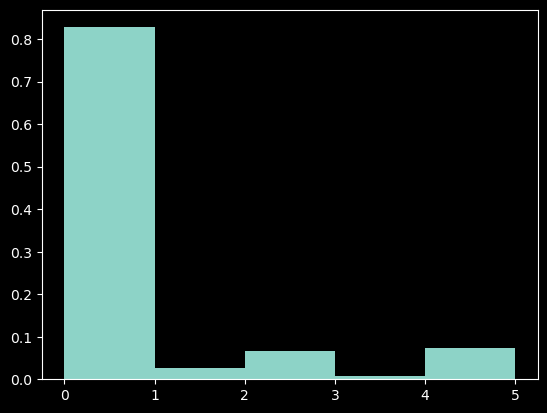

In [9]:
plt.hist(Y_train, bins=np.arange(Y_train.min(), Y_train.max() + 2), density=True)

In [10]:
print(Y_train.value_counts())

0.000000000000000000e+00.88
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


## One-Hot Encoding with Keras

In [11]:
Y_train = keras.utils.to_categorical(Y_train, nclasses)
Y_test = keras.utils.to_categorical(Y_test, nclasses)

In [12]:
Y_train[:10]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [13]:
Y_train.shape

(87553, 5)

In [14]:
Y_test.shape

(21891, 5)

## Train dataset partitioning into Train (SubTrain) and Validation datasets
We are going tou use stratified sampling to partition the train dataset into train and validation datasets. The stratification is based on the label distribution.

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=SEED, stratify=Y_train
)

In [16]:
# Check distributions
y_train_labels = np.argmax(Y_train, axis=1)
y_val_labels = np.argmax(Y_val, axis=1)

train_count = Counter(y_train_labels)
train_percentages = {
    label: (count / len(y_train_labels)) * 100 for label, count in train_count.items()
}
val_count = Counter(y_val_labels)
val_percentages = {
    label: (count / len(y_val_labels)) * 100 for label, count in val_count.items()
}

print("Train distribution: ", train_percentages)
print("Validation distribution: ", val_percentages)

Train distribution:  {0: 82.773193226921, 4: 7.345592644413353, 2: 6.610319522572171, 3: 0.7324176922417978, 1: 2.538476913851689}
Validation distribution:  {0: 82.77082976414825, 1: 2.5412597795671292, 2: 6.612986123008395, 3: 0.7309691051339158, 4: 7.3439552281423115}


## Construction of neural network with simple feedforward architecture (2 layers)

In [17]:
input_dim = X_train.shape[1]

In [18]:
input_dim

187

In [19]:
INPUT_SHAPE = (input_dim,)

In [20]:
model = Sequential()
model.add(Dense(64, input_shape=INPUT_SHAPE, activation="relu"))
model.add(Dense(nclasses, activation="softmax"))

2023-10-16 16:37:58.825605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:913] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-16 16:37:58.839808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:913] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-16 16:37:58.839933: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:913] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                12032     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 12357 (48.27 KB)
Trainable params: 12357 (48.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


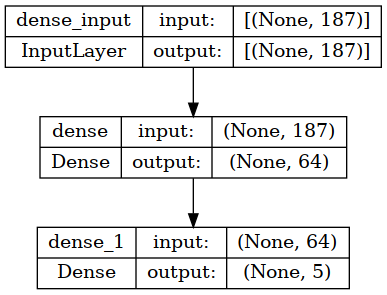

In [22]:
keras.utils.plot_model(model, show_shapes=True)

## Definition of:
- ### Training hyperparameters (Learning Rate, Loss Function, Optimizer, Batch Size, Epochs).
- ### Target metrics


In [23]:
LR = 0.0001
BATCH_SIZE = 200
EPOCHS = 100
DROP_RATE = 0.3
opt = Adam(learning_rate=LR)

In [24]:
from keras import backend as K

METRICS = [
         tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
         tf.keras.metrics.Precision(),
         tf.keras.metrics.Recall(),
         tf.keras.metrics.AUC()
       ]

In [25]:
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=METRICS)

## Training

In [26]:
training_history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=TensorBoard(TBLOGDIRS["mitbih"], histogram_freq=1),
    verbose=VERBOSE,
)

Epoch 1/100


2023-10-16 16:38:00.049603: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbf8894b010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-16 16:38:00.049617: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-10-16 16:38:00.053148: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-16 16:38:00.063070: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:440] Loaded cuDNN version 8902
I0000 00:00:1697485080.114393  949008 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 [==============================] - 2s 2ms/step - loss: 0.9349 - accuracy: 0.7880 - precision: 0.7901 - recall: 0.4694 - auc: 0.8986 - val_loss: 0.7120 - val_accuracy: 0.8279 - val_precision: 0.8241 - val_recall: 0.7515 - val_auc: 0.9258
Epoch 2/100
351/351 [==============================] - 1s 2ms/step - loss: 0.6211 - accuracy: 0.8362 - precision: 0.8472 - recall: 0.8039 - auc: 0.9431 - val_loss: 0.5422 - val_accuracy: 0.8532 - val_precision: 0.8680 - val_recall: 0.8324 - val_auc: 0.9535
Epoch 3/100
351/351 [==============================] - 1s 2ms/step - loss: 0.5014 - accuracy: 0.8698 - precision: 0.8853 - recall: 0.8469 - auc: 0.9596 - val_loss: 0.4604 - val_accuracy: 0.8799 - val_precision: 0.8968 - val_recall: 0.8597 - val_auc: 0.9648
Epoch 4/100
351/351 [==============================] - 1s 2ms/step - loss: 0.4419 - accuracy: 0.8837 - precision: 0.8990 - recall: 0.8654 - auc: 0.9673 - val_loss: 0.4192 - val_accuracy: 0.8882 - val_precision: 0.9054 - val_recall: 0.8719 - 

## Model Evaluation

In [32]:
def evaluate_and_plot(training_history, model, X_train, Y_train, X_val, Y_val, X_test, Y_test):
    # evaluate with training data
    train_results = model.evaluate(X_train, Y_train, verbose=0)
    print("Traing metrics:")
    for name, value in zip(model.metrics_names, train_results):
        print(f"{name}: {value:.4f}")
    
    # evaluate with validation data
    val_results = model.evaluate(X_val, Y_val, verbose=0)
    print("\nValidation metrics:")
    for name, value in zip(model.metrics_names, val_results):
        print(f"{name}: {value:.4f}")

    # evaluate with test data
    test_results = model.evaluate(X_test, Y_test, verbose=0)
    print("\nTest metrics:")
    for name, value in zip(model.metrics_names, test_results):
        print(f"{name}: {value:.4f}")

    # Trained model analysis and evaluation
    f, ax = plt.subplots(2,1, figsize=(5,5))
    ax[0].plot(training_history.history['loss'], label="Loss")
    ax[0].plot(training_history.history['val_loss'], label="Validation loss")
    ax[0].set_title('%s: loss' % 'Cardiopathy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # Accuracy
    ax[1].plot(training_history.history['accuracy'], label="Accuracy")
    ax[1].plot(training_history.history['val_accuracy'], label="Validation accuracy")
    ax[1].set_title('%s: accuracy' % 'Cardiopathy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    test_pred = model.predict(X_test)
    test_pred = np.argmax(test_pred, axis=1)
    test_truth = np.argmax(Y_test, axis=1)
    df = pd.DataFrame()
    df['y_test'] = test_pred
    df['Class'] = test_truth
    df['Correct'] = test_pred==test_truth
    acc_by_category = df.groupby('Class').agg({'Correct':'mean'})
    acc_by_category['Correct'].plot(kind='bar', title='Accuracy by %s' % 'Cardiopathy', colormap = 'Paired')
    plt.ylabel('Accuracy')
    plt.show()


Traing metrics:
loss: 0.1331
accuracy: 0.9632
precision: 0.9664
recall: 0.9607
auc: 0.9961

Validation metrics:
loss: 0.1415
accuracy: 0.9608
precision: 0.9637
recall: 0.9576
auc: 0.9953

Test metrics:
loss: 0.1461
accuracy: 0.9588
precision: 0.9618
recall: 0.9568
auc: 0.9951


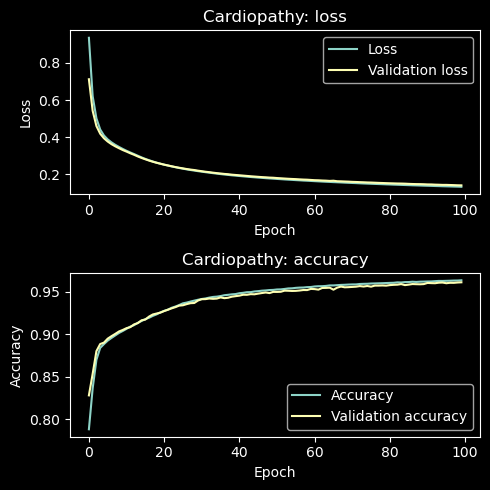

685/685 [==============================] - 0s 482us/step


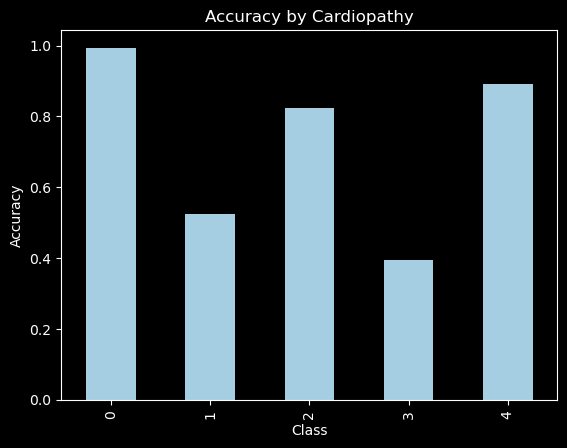

In [33]:
evaluate_and_plot(training_history, model, X_train, Y_train, X_val, Y_val, X_test, Y_test)

## Conclusions from the Cardiopathy Model:


### Training Dynamics:
- **Loss Graph**: Both the training and validation losses decrease rapidly during the initial epochs and then seem to plateau. This pattern suggests effective learning without significant overfitting, as the validation loss mirrors the training loss closely.
  
- **Accuracy Graph**: Training and validation accuracy both show improvement and stabilization. It's notable that validation accuracy converges closely with training accuracy, indicating good generalization.

### Model Performance:
- The model demonstrates an impressive overall accuracy of approximately **~97%**. This high score means the model is quite adept at classifying cardiopathy cases in this dataset.

- **Classification Report Insights**:
  - *Class 0* and *Class 4* have standout performance with high precision, recall, and F1-scores. This means the model can detect and correctly classify these classes very reliably.
  - Other classes, while not as high as Class 0 and 4, still show competent performance metrics, suggesting the model's ability to handle multi-class classification challenges.
  

### Recommendations for Improvement:
   - Given the disparity in performance across classes, it might be beneficial to investigate techniques like data augmentation, class weighting, or oversampling for the underrepresented classes to improve the model's performance on them.
   - Regularization techniques, like dropout or L2 regularization, could be employed to address the potential overfitting observed from the training dynamics.
   - A more complex model architecture or the inclusion of additional features might help in enhancing the prediction capabilities for classes with lower F1-scores.

# Next Steps

## Model 2: A 3-layer network using the dropout regularization technique

In [29]:
model2 = Sequential()

# First layer
model2.add(Dense(128, activation='relu', input_shape=INPUT_SHAPE))
model2.add(Dropout(0.5))  # 50% dropout

# Second layer
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))  # 50% dropout

# Third layer
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.5))  # 50% dropout

# Output layer
model2.add(Dense(nclasses, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

# Summary of the model2 architecture
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               24064     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 5)                

In [30]:
training_history2 = model2.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=TensorBoard(TBLOGDIRS["mitbih"], histogram_freq=1),
    verbose=VERBOSE,
)

Epoch 1/100
351/351 [==============================] - 2s 3ms/step - loss: 0.6103 - accuracy: 0.8593 - precision: 0.9110 - recall: 0.8001 - auc: 0.9664 - val_loss: 0.3545 - val_accuracy: 0.8999 - val_precision: 0.9334 - val_recall: 0.8618 - val_auc: 0.9813
Epoch 2/100
351/351 [==============================] - 1s 2ms/step - loss: 0.3903 - accuracy: 0.8936 - precision: 0.9240 - recall: 0.8610 - auc: 0.9772 - val_loss: 0.2692 - val_accuracy: 0.9263 - val_precision: 0.9326 - val_recall: 0.9199 - val_auc: 0.9877
Epoch 3/100
351/351 [==============================] - 1s 2ms/step - loss: 0.3220 - accuracy: 0.9163 - precision: 0.9357 - recall: 0.8969 - auc: 0.9830 - val_loss: 0.2217 - val_accuracy: 0.9340 - val_precision: 0.9529 - val_recall: 0.9274 - val_auc: 0.9917
Epoch 4/100
351/351 [==============================] - 1s 2ms/step - loss: 0.2920 - accuracy: 0.9228 - precision: 0.9416 - recall: 0.9066 - auc: 0.9856 - val_loss: 0.2028 - val_accuracy: 0.9388 - val_precision: 0.9517 - val_recal

Traing metrics:
loss: 0.0771
accuracy: 0.9779
precision: 0.9797
recall: 0.9765
auc: 0.9984

Validation metrics:
loss: 0.1004
accuracy: 0.9729
precision: 0.9742
recall: 0.9712
auc: 0.9972

Test metrics:
loss: 0.1028
accuracy: 0.9721
precision: 0.9737
recall: 0.9709
auc: 0.9968


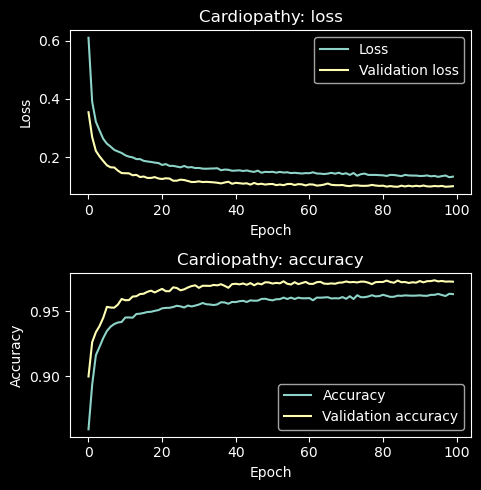

685/685 [==============================] - 0s 518us/step


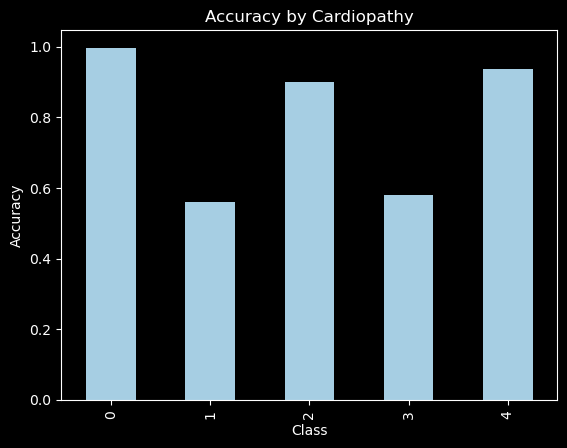

In [34]:
evaluate_and_plot(training_history2, model2, X_train, Y_train, X_val, Y_val, X_test, Y_test)

## Conclusion for the Second Neural Network Model

### Training Dynamics:
- **Loss Graph**: The training and validation losses both demonstrate a decline, with the validation loss closely following the training loss trajectory. This suggests the model learned the patterns effectively without severe overfitting.
  
- **Accuracy Graph**: Both training and validation accuracy increase as epochs progress. There's a slight convergence between the two, implying the model's decent generalization capabilities.

### Model Performance:
- The model achieved an overall accuracy of roughly **97.2%**, which is quite commendable. This indicates that the model effectively classifies the cardiopathy instances in this dataset.

- **Classification Report Insights**:
  - *Class 0* and *Class 4* have especially strong metrics, with both precision and recall approaching or at 1. This suggests the model is very reliable for these particular classes.
  - *Class 2* also exhibits good precision and recall, indicating reliable classification.
  - *Class 1* and *Class 3*, while still reasonably classified, have somewhat lower metrics compared to the other classes. This suggests there might be some room for improvement in distinguishing these cardiopathy types.

In summary, the second neural network model showcases solid performance on the cardiopathy dataset. While there are areas of potential enhancement, particularly with Classes 1 and 3, the model's general proficiency is evident in its high overall accuracy.


## Model 3: A 6-layer network using early stopping

In [46]:
model3 = Sequential()

# First layer
model3.add(Dense(1024, activation='relu', input_shape=INPUT_SHAPE))
model3.add(Dropout(DROP_RATE))

# Second layer
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(DROP_RATE))

# Third layer
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(DROP_RATE))

# # Fourth layer
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(DROP_RATE))

# Fifth layer
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(DROP_RATE))

# Sixth layer
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(DROP_RATE))

model3.add(Dense(nclasses, activation='softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

# Summary of the model3 architecture
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 1024)              192512    
                                                                 
 dropout_24 (Dropout)        (None, 1024)              0         
                                                                 
 dense_32 (Dense)            (None, 512)               524800    
                                                                 
 dropout_25 (Dropout)        (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 256)               131328    
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 128)              

In [47]:
# Set up early stopping. Monitor the validation loss and stop training once it starts increasing.
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


training_history3 = model3.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stop, TensorBoard(TBLOGDIRS["mitbih"], histogram_freq=1)],
    verbose=VERBOSE,
)

Epoch 1/100
351/351 [==============================] - 2s 3ms/step - loss: 0.4022 - accuracy: 0.9114 - precision: 0.9408 - recall: 0.8841 - auc: 0.9833 - val_loss: 0.2368 - val_accuracy: 0.9315 - val_precision: 0.9431 - val_recall: 0.9196 - val_auc: 0.9903
Epoch 2/100
351/351 [==============================] - 1s 3ms/step - loss: 0.2365 - accuracy: 0.9389 - precision: 0.9528 - recall: 0.9268 - auc: 0.9895 - val_loss: 0.1670 - val_accuracy: 0.9525 - val_precision: 0.9606 - val_recall: 0.9473 - val_auc: 0.9946
Epoch 3/100
351/351 [==============================] - 1s 3ms/step - loss: 0.1929 - accuracy: 0.9499 - precision: 0.9589 - recall: 0.9419 - auc: 0.9923 - val_loss: 0.1504 - val_accuracy: 0.9591 - val_precision: 0.9673 - val_recall: 0.9487 - val_auc: 0.9956
Epoch 4/100
351/351 [==============================] - 1s 3ms/step - loss: 0.1766 - accuracy: 0.9551 - precision: 0.9617 - recall: 0.9477 - auc: 0.9931 - val_loss: 0.1330 - val_accuracy: 0.9652 - val_precision: 0.9692 - val_recal

Traing metrics:
loss: 0.0497
accuracy: 0.9847
precision: 0.9858
recall: 0.9841
auc: 0.9994

Validation metrics:
loss: 0.0748
accuracy: 0.9789
precision: 0.9796
recall: 0.9781
auc: 0.9981

Test metrics:
loss: 0.0879
accuracy: 0.9769
precision: 0.9778
recall: 0.9761
auc: 0.9973


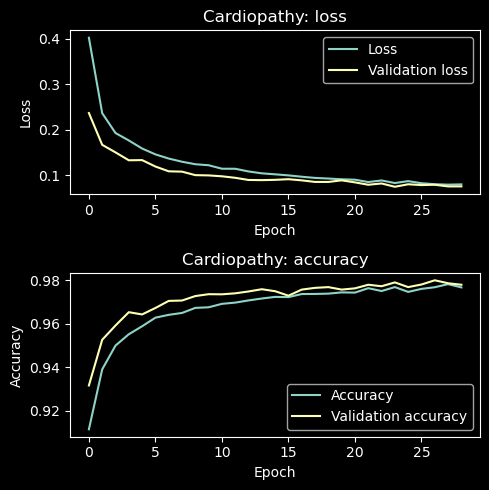

685/685 [==============================] - 0s 632us/step


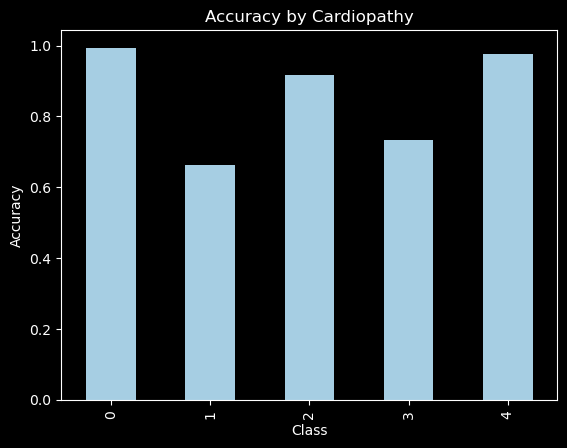

In [48]:
evaluate_and_plot(training_history3, model3, X_train, Y_train, X_val, Y_val, X_test, Y_test)

### Ejercicio 3. Pongase creativo e implemente y evalue una red neuronal a gusto, que utilice al menos 2 técnicas vistas en el teórico

In [49]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming y_train_labels is a 1D array with the labels
unique_classes = np.unique(y_train_labels)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_labels)

# Convert to dictionary for compatibility with Keras
class_weight_dict = {i: class_weights[i] for i in unique_classes}


In [50]:
class_weight_dict

{0: 0.241624120325652,
 1: 7.878740157480315,
 2: 3.025572354211663,
 3: 27.30682261208577,
 4: 2.722721088435374}

In [57]:
# Initialize the model4
model4 = Sequential()

# Input Layer
model4.add(Dense(2048, activation='relu', input_shape=(187,)))  # 187 features
model4.add(BatchNormalization())
model4.add(Dropout(DROP_RATE))

# Hidden Layer 1
model4.add(Dense(1024, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(DROP_RATE))

# Hidden Layer 2
model4.add(Dense(512, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(DROP_RATE))

# Hidden Layer 3
model4.add(Dense(256, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(DROP_RATE))

# Hidden Layer 4
model4.add(Dense(128, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(DROP_RATE))

# Hidden Layer 5
model4.add(Dense(64, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(DROP_RATE))

# Output Layer
model4.add(Dense(nclasses, activation='softmax'))  # 5 classes

# Compile the model4
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

# Summary
model4.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 2048)              385024    
                                                                 
 batch_normalization_6 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dropout_36 (Dropout)        (None, 2048)              0         
                                                                 
 dense_47 (Dense)            (None, 1024)              2098176   
                                                                 
 batch_normalization_7 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dropout_37 (Dropout)        (None, 1024)            

In [58]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

training_history4 = model4.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=TensorBoard(TBLOGDIRS["mitbih"], histogram_freq=1),
    verbose=VERBOSE,
    class_weight=class_weight_dict
)

Epoch 1/100
351/351 [==============================] - 4s 6ms/step - loss: 1.3915 - accuracy: 0.3430 - precision: 0.3644 - recall: 0.2283 - auc: 0.6738 - val_loss: 1.0566 - val_accuracy: 0.4834 - val_precision: 0.4829 - val_recall: 0.3949 - val_auc: 0.8554
Epoch 2/100
351/351 [==============================] - 2s 5ms/step - loss: 0.8055 - accuracy: 0.5329 - precision: 0.5592 - recall: 0.3724 - auc: 0.8306 - val_loss: 0.7501 - val_accuracy: 0.7323 - val_precision: 0.7553 - val_recall: 0.6252 - val_auc: 0.9274
Epoch 3/100
351/351 [==============================] - 2s 5ms/step - loss: 0.6483 - accuracy: 0.6684 - precision: 0.6972 - recall: 0.5236 - auc: 0.8883 - val_loss: 0.7156 - val_accuracy: 0.7669 - val_precision: 0.7909 - val_recall: 0.7006 - val_auc: 0.9328
Epoch 4/100
351/351 [==============================] - 2s 5ms/step - loss: 0.5929 - accuracy: 0.7118 - precision: 0.7448 - recall: 0.5889 - auc: 0.9062 - val_loss: 0.7227 - val_accuracy: 0.7666 - val_precision: 0.7821 - val_recal

Traing metrics:
loss: 0.1402
accuracy: 0.9490
precision: 0.9515
recall: 0.9469
auc: 0.9964

Validation metrics:
loss: 0.1635
accuracy: 0.9431
precision: 0.9455
recall: 0.9408
auc: 0.9947

Test metrics:
loss: 0.1735
accuracy: 0.9398
precision: 0.9424
recall: 0.9372
auc: 0.9945


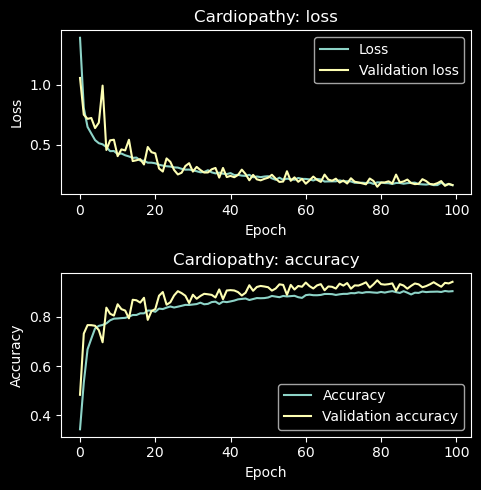

685/685 [==============================] - 1s 810us/step


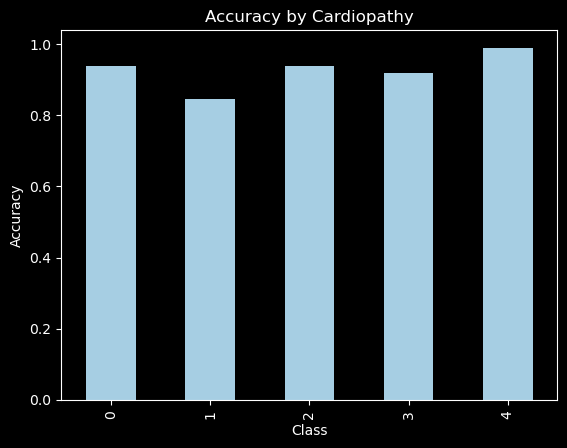

In [59]:
evaluate_and_plot(training_history4, model4, X_train, Y_train, X_val, Y_val, X_test, Y_test)

## Neural Network Model Summaries

### Model 1
- **Type**: Simple neural network
- **Layers**: 1 input layer (64 neurons), 1 output layer
- **Special Features**: None

### Model 2
- **Type**: Neural network with dropout
- **Layers**: 1 input layer (128 neurons), 2 hidden layers, 1 output layer
- **Special Features**: Dropout for regularization

### Model 3
- **Type**: Deeper neural network with dropout
- **Layers**: 1 input layer (1024 neurons), 5 hidden layers, 1 output layer
- **Special Features**: Dropout for regularization and early stopping

### Model 4
- **Type**: Deep neural network with extra features
- **Layers**: 1 input layer (2048 neurons), 5 hidden layers, 1 output layer
- **Special Features**: Dropout, batch normalization and early stopping

## Justification for Model 4's Superior Performance

- **Class-specific Accuracy**: 
    Model 4 exhibits high recall accuracy for classes signaling abnormal behaviors, crucial for medical predictions to minimize false negatives. The efficiency in distinguishing between normal and abnormal classes can be observed in the 'Accuracy by Cardiopathy' graph.

- **Class Weight Application**: 
    By incorporating class weights during training, Model 4 avoids biases towards larger classes and acknowledges the importance of under-represented classes, essential when diagnosing rare but severe conditions.

- **Regularization Techniques**: 
    Model 4 employs regularization methods like dropout, batch normalization, and early stopping. These techniques prevent overfitting, stabilize training, lead to faster convergence, and ensure optimal learned weights are used.

- **Consistent Class Accuracy**: 
    The 'Accuracy by Cardiopathy' graph reveals minimal variance in accuracy across classes, suggesting that Model 4 performs uniformly and doesn't favor any particular class.

Given these points, it's evident that Model 4 is a robust choice for predicting heart diseases compared to other models.
